# Run meta-analyses on 21 pain studies
Collection of NIDM-Results packs downloaded from Neurovault collection [1425](https://www.neurovault.org/collections/1425/), uploaded by Dr. Camille Maumet.

In [1]:
%matplotlib inline
import json
import numpy as np
from glob import glob
from os.path import basename, join, dirname, isfile

import pandas as pd
import nibabel as nib
from scipy.stats import t
from nilearn.masking import apply_mask
from nilearn.plotting import plot_stat_map

import nimare
from nimare.meta.ibma import (stouffers, fishers, weighted_stouffers,
                              rfx_glm, ffx_glm)

In [2]:
dset_file = '/Users/tsalo/Documents/tsalo/NiMARE/nimare/tests/data/nidm_pain_dset.json'
with open(dset_file, 'r') as fo:
    dset_dict = json.load(fo)
db = nimare.dataset.Database(dset_file)
dset = db.get_dataset()

mask_img = dset.mask

logp_thresh = -np.log(.05)

## Define functions for querying set of NIDM-Results packs

In [3]:
def _get_file(cdict, t):
    """Return the file associated with a given data type within a
    folder if it exists. Otherwise, returns an empty list.
    """
    temp = ''
    if t == 'con':
        temp = cdict['images'].get('con')
    elif t == 'se':
        temp = cdict['images'].get('se')
    elif t == 't':
        temp = cdict['images'].get('t')
    elif t == 'z':
        temp = cdict['images'].get('z')
    elif t == 'n':
        temp = cdict.get('sample_sizes', [])
        if temp:
            temp = np.mean(temp)
    else:
        raise Exception('Input type "{0}" not recognized.'.format(t))

    return temp


def get_files(ddict, types):
    """Returns a list of files associated with a given data type 
    from a set of subfolders within a directory. Allows for
    multiple data types and only returns a set of files from folders
    with all of the requested types.
    """
    all_files = []
    for study in ddict.keys():
        files = []
        cdict = ddict[study]['contrasts']['1']
        for t in types:
            temp = _get_file(cdict, t)
            if temp:
                files.append(temp)
            
        if len(files) == len(types):
            all_files.append(files)
    all_files = list(map(list, zip(*all_files)))
    return all_files

## Get z-maps

In [4]:
files = get_files(dset_dict, ['z'])
z_imgs = [nib.load(f) for f in files[0]]
z_data = apply_mask(z_imgs, mask_img)
print('{0} studies found.'.format(z_data.shape[0]))

11 studies found.


## Fisher's

CPU times: user 1.26 s, sys: 209 ms, total: 1.47 s
Wall time: 1.48 s


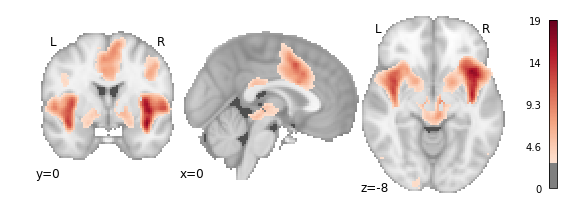

In [5]:
%%time
result = fishers(z_data, mask_img)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Stouffer's

### Fixed-effects inference

CPU times: user 956 ms, sys: 62 ms, total: 1.02 s
Wall time: 1.03 s


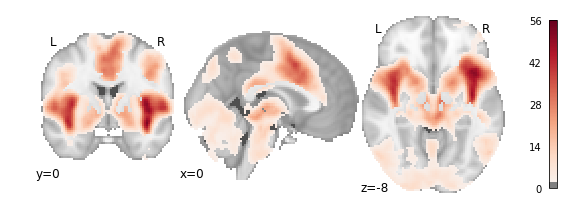

In [6]:
%%time
result = stouffers(z_data, mask_img, inference='ffx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

### Random-effects inference with theoretical null distribution

CPU times: user 1.24 s, sys: 90.6 ms, total: 1.33 s
Wall time: 1.44 s


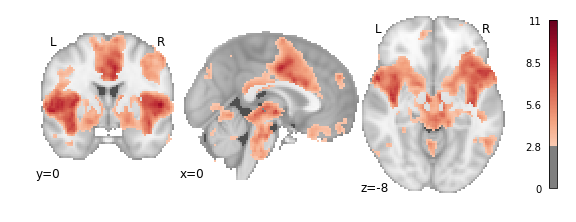

In [7]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

### Random-effects inference with empirical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


CPU times: user 2min 16s, sys: 13 s, total: 2min 29s
Wall time: 2min 36s


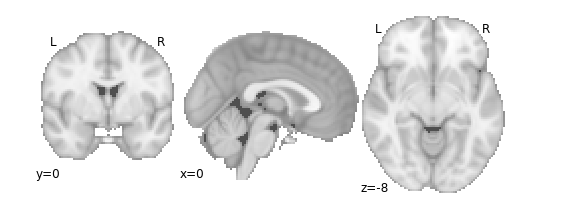

In [8]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='empirical', n_iters=1000)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Get z-maps + sample sizes

In [9]:
z_files, ns = get_files(dset_dict, ['z', 'n'])
z_imgs = [nib.load(f) for f in z_files]
z_data = apply_mask(z_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(z_data.shape[0]))

11 studies found.


## Weighted Stouffer's

CPU times: user 1.29 s, sys: 137 ms, total: 1.43 s
Wall time: 1.55 s


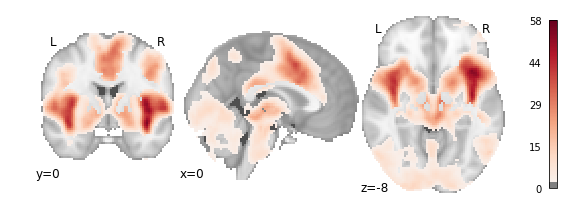

In [10]:
%%time
result = weighted_stouffers(z_data, sample_sizes, mask_img)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Get contrast maps + contrast standard error maps + sample sizes

In [11]:
con_files, se_files, ns = get_files(dset_dict, ['con', 'se', 'n'])
con_imgs = [nib.load(f) for f in con_files]
se_imgs = [nib.load(f) for f in se_files]
con_data = apply_mask(con_imgs, mask_img)
se_data = apply_mask(se_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(con_data.shape[0]))

21 studies found.


## FFX GLM

CPU times: user 1.47 s, sys: 195 ms, total: 1.66 s
Wall time: 1.99 s


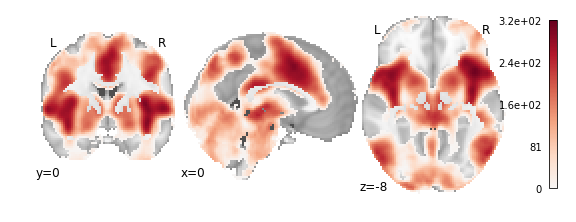

In [12]:
%%time
result = ffx_glm(con_data, se_data, sample_sizes, mask_img, equal_var=True)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## Get contrast maps

In [13]:
con_files = get_files(dset_dict, ['con'])
con_files = con_files[0]
con_imgs = [nib.load(f) for f in con_files]
con_data = apply_mask(con_imgs, mask_img)
print('{0} studies found.'.format(con_data.shape[0]))

21 studies found.


## RFX GLM

### Theoretical null distribution

CPU times: user 1.31 s, sys: 116 ms, total: 1.42 s
Wall time: 1.54 s


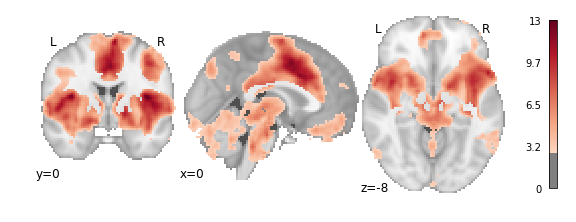

In [14]:
%%time
result = rfx_glm(con_data, mask_img, null='theoretical', n_iters=None)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

### Empirical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


CPU times: user 2min 40s, sys: 21.6 s, total: 3min 2s
Wall time: 3min 12s


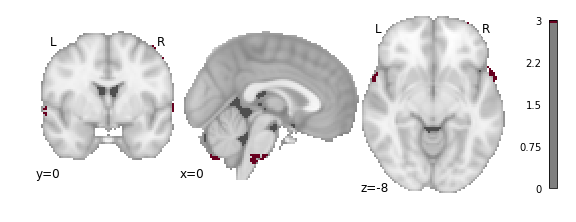

In [15]:
%%time
result = rfx_glm(con_data, mask_img, null='empirical', n_iters=1000)
plot_stat_map(result.images['log_p'], threshold=logp_thresh,
              cut_coords=[0, 0, -8], draw_cross=False,
              cmap='RdBu_r')

## MKDA

### Density analysis

CPU times: user 2.5 s, sys: 628 ms, total: 3.13 s
Wall time: 12.4 s


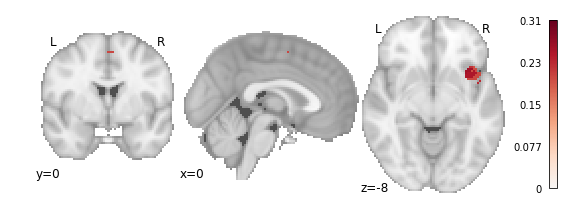

In [16]:
%%time
mkda = nimare.meta.cbma.MKDADensity(dset, ids=dset.ids, kernel__r=10)
mkda.fit(n_iters=10)
plot_stat_map(mkda.results.images['vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FDR correction

CPU times: user 1.94 s, sys: 284 ms, total: 2.22 s
Wall time: 2.31 s


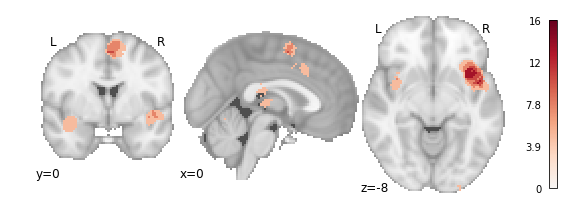

In [17]:
%%time
mkda2 = nimare.meta.cbma.MKDAChi2(dset, ids=dset.ids, ids2=dset.ids, kernel__r=10)
mkda2.fit(corr='FDR')
plot_stat_map(mkda2.results.images['pAgF_z_FDR_05'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FWE correction

CPU times: user 50.7 s, sys: 11.4 s, total: 1min 2s
Wall time: 1min 10s


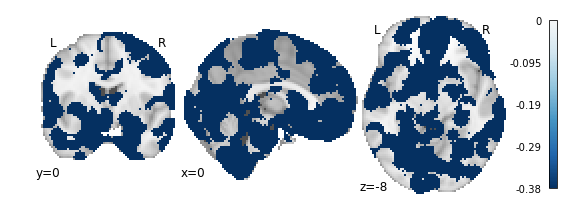

In [18]:
%%time
mkda3 = nimare.meta.cbma.MKDAChi2(dset, ids=dset.ids, ids2=dset.ids, kernel__r=10)
mkda3.fit(corr='FWE', n_iters=10)
plot_stat_map(mkda3.results.images['pAgF_z_FWE_05'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## KDA

CPU times: user 1.57 s, sys: 276 ms, total: 1.85 s
Wall time: 12.6 s


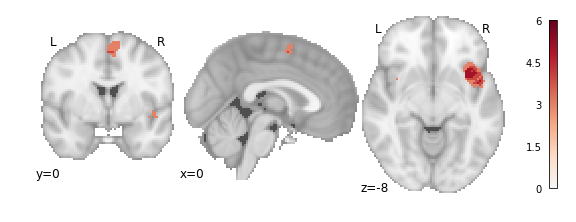

In [19]:
%%time
kda = nimare.meta.cbma.KDA(dset, ids=dset.ids, kernel__r=10)
kda.fit(n_iters=10)
plot_stat_map(kda.results.images['vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## ALE

CPU times: user 2.69 s, sys: 618 ms, total: 3.31 s
Wall time: 15.1 s


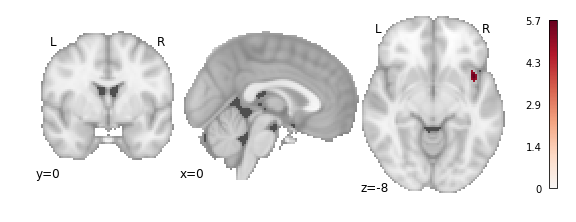

In [20]:
%%time
ale = nimare.meta.cbma.ALE(dset, ids=dset.ids)
ale.fit(n_iters=10)
plot_stat_map(ale.results.images['vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## SCALE

CPU times: user 51.3 s, sys: 12.3 s, total: 1min 3s
Wall time: 1min 23s


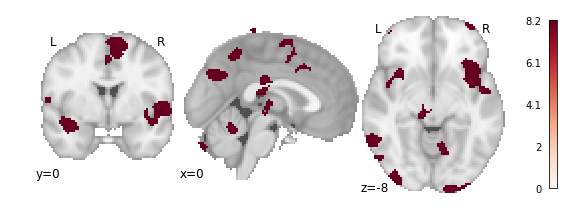

In [21]:
%%time
ijk = np.vstack(np.where(dset.mask.get_data())).T
scale = nimare.meta.cbma.SCALE(dset, ids=dset.ids, ijk=ijk)
scale.fit(n_iters=10)
plot_stat_map(scale.results.images['vthresh'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')